In [43]:
import os
from functools import partial
import torch
import numpy as np
import numpy.random as rnd
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [44]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [45]:
from pyro.nn import module
from pyro.nn import PyroSample
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.contrib.bnn import HiddenLayer

In [46]:
from util import summary

## Simulate data

In [47]:
def gen_input(freq_ub=1, num_freq=100, T=100):
    "Generate input signal with random frequencies"
    
    # Generate time index
    t = np.arange(T)

    # Randomly sample frequencies 
    Ω = rnd.rand(num_freq)*freq_ub

    # Generate mix of cosines of different frequencies
    u = np.zeros((T,num_freq))
    for i,ω in enumerate(Ω):
        u[:,i] = np.cos(ω*t)
    
    return np.mean(u, axis=1)

In [48]:
def narx_output(u, θ, σ, ϕ, order_y=0, order_u=1, T=100):
    "Generate Nonlinear Auto-Regressive with eXogenous input function"
    
    # Maximum order
    max_order = max(order_y, order_u)
    tot_order = 1 + order_u + order_y
    
    # Initialize
    y = np.zeros((T))
    x = np.zeros((T,tot_order))
    
    for k in range(max_order,T):

        # Current input
        x[k,0] = u[k]

        # Previous inputs
        for i in range(order_u):
            x[k,1+i] = u[k-i-1]

        # Previous outputs
        for j in range(order_y):
            x[k, 1+order_u+j] = y[k-j-1]
            
        # NARX ouput
        y[k] = θ @ ϕ(x[k,:]) + σ*rnd.randn(1)
        
    return y,x

In [49]:
# Length of training signal
T_trn = 300

# Length of validation signal
T_val = 300

# Length of transient part
ix_transient = 50

In [50]:
# Input signals
trn_input = gen_input(freq_ub = 0.5, T = T_trn)
val_input = gen_input(freq_ub = 1.0, T = T_val)

In [51]:
# Define orders
order_u = 2
order_y = 2
order = 1 + order_u + order_y

# Nonlinear transition
def ϕ(x):
    return np.hstack((x, x**3)).T
M = order*2

# Generate coefficients
θ = rnd.randn(M)/4

# Generate noise
σ = np.sqrt(1e-4)

# NARX output
trn_output, trn_features = narx_output(trn_input, θ, σ, ϕ, order_y=order_y, order_u=order_u, T=T_trn)
val_output, val_features = narx_output(val_input, θ, σ, ϕ, order_y=order_y, order_u=order_u, T=T_val)

In [52]:
# Remove transients
trn_input = trn_input[ix_transient:]
trn_features = trn_features[ix_transient:]
trn_output = trn_output[ix_transient:]

val_input = val_input[ix_transient:]
val_features = val_features[ix_transient:]
val_output = val_output[ix_transient:]

# Cut time horizons
T_trn -= ix_transient
T_val -= ix_transient

# Generate time indices
t_trn = np.arange(T_trn)
t_val = np.arange(T_val)

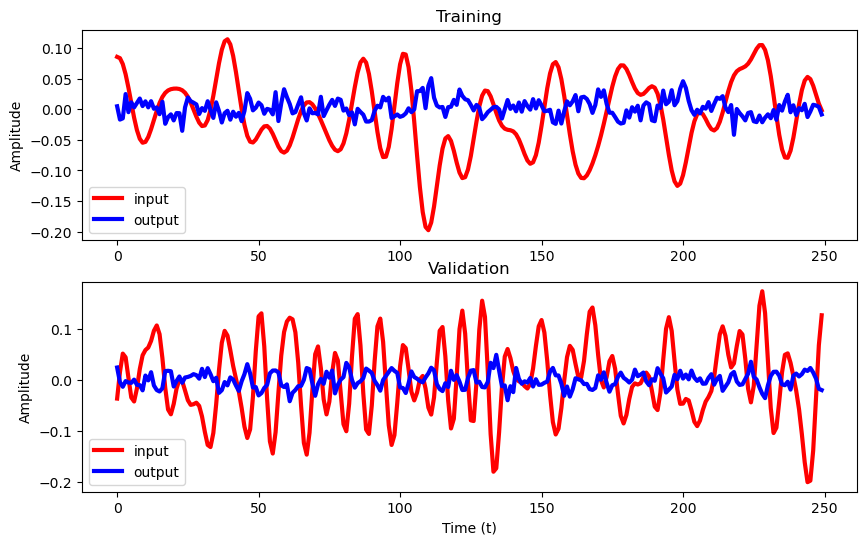

In [53]:
fig = plt.figure(figsize=(10,6))
ax = fig.subplots(2)

ax[0].plot(t_trn, trn_input, c="red", lw=3, label="input");
ax[0].plot(t_trn, trn_output, c="blue", lw=3, label="output"); 
ax[0].set_title("Training");
ax[0].set_ylabel("Amplitude");
ax[0].legend();

ax[1].plot(t_val, val_input, c="red", lw=3, label="input");
ax[1].plot(t_val, val_output, c="blue", lw=3, label="output"); 
ax[1].set_title("Validation");
ax[1].set_xlabel("Time (t)");
ax[1].set_ylabel("Amplitude");
ax[1].legend();

In [54]:
# Cast to tensors
trn_u = torch.tensor(trn_input, dtype=torch.float)
trn_x = torch.tensor(trn_features, dtype=torch.float)
trn_y = torch.tensor(trn_output, dtype=torch.float)

val_u = torch.tensor(val_input, dtype=torch.float)
val_x = torch.tensor(val_features, dtype=torch.float)
val_y = torch.tensor(val_output, dtype=torch.float)

## Model 1: Bayesian linear regression

In [55]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 1))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [56]:
# Define model and inference procedure
model = BayesianRegression(5, 1)
guide = AutoDiagonalNormal(model)
adam = Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [57]:
pyro.clear_param_store()

# Train model
num_iterations = 5000
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(trn_x, trn_y)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T_trn))

[iteration 0001] loss: 4.7691
[iteration 0501] loss: -2.8998
[iteration 1001] loss: -2.9531
[iteration 1501] loss: -2.9577
[iteration 2001] loss: -2.8707
[iteration 2501] loss: -2.8592
[iteration 3001] loss: -2.9630
[iteration 3501] loss: -2.9487
[iteration 4001] loss: -2.9270
[iteration 4501] loss: -2.9749


### Model evaluation

In [58]:
# Make predictions
predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("linear.weight", "obs", "_RETURN"))
samples_BLR = predictive(val_x)
pred_summary = summary(samples_BLR)
mu_BLR = pred_summary["_RETURN"]

In [59]:
MSE_BLR = np.array(torch.mean((val_y - mu_BLR["mean"])**2))

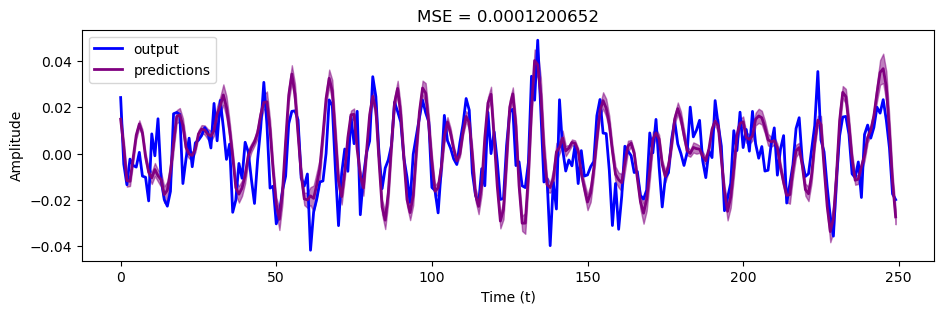

In [60]:
# Plot generated input signal
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y, c="blue", lw=2, label="output"); 
ax.plot(t_val, mu_BLR["mean"], c="purple", lw=2, label="predictions")
ax.fill_between(t_val, mu_BLR["5%"], mu_BLR["95%"], color="purple", alpha=0.5)
ax.set_title("MSE = " + str(MSE_BLR));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [61]:
fig.savefig("figures/bayesian-linear-regression.png");

## Model 2: Bayesian neural network

In [62]:
# Define network architecture
neural_network = nn.Sequential(
     nn.Linear(5, 25),
     nn.LeakyReLU(),
     nn.Linear(25, 1)
 )
 
module.to_pyro_module_(neural_network)
 
for m in neural_network.modules():
    for name, value in list(m.named_parameters(recurse=False)):
        setattr(m, name, module.PyroSample(prior=dist.Normal(0, 1).expand(value.shape).to_event(value.dim())))

In [63]:
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, neural_network):
        super().__init__()
        self.neural_network = neural_network

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0, 1))
        mean = self.neural_network(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [64]:
# Define model and inference procedure
model = BayesianNeuralNetwork(neural_network)
guide = AutoDiagonalNormal(model)
optimizer = Adam({"lr": 0.03}) 
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [65]:
pyro.clear_param_store()

# Train model
num_iterations = 5000
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(trn_x, trn_y)
    if j % 500 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / T_trn))

[iteration 0001] loss: 3.5593
[iteration 0501] loss: -1.7559
[iteration 1001] loss: -2.0788
[iteration 1501] loss: -2.2945
[iteration 2001] loss: -2.3373
[iteration 2501] loss: -2.2222
[iteration 3001] loss: -1.7986
[iteration 3501] loss: -2.3398
[iteration 4001] loss: -2.3050
[iteration 4501] loss: -2.5131


### Model evaluation

In [66]:
# Make predictions
predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("linear.weight", "obs", "_RETURN"))
samples_BNN = predictive(val_x)
pred_summary = summary(samples_BNN)
mu_BNN = pred_summary["_RETURN"]

In [67]:
MSE_BNN = np.array(torch.mean((val_y - mu_BNN["mean"])**2))

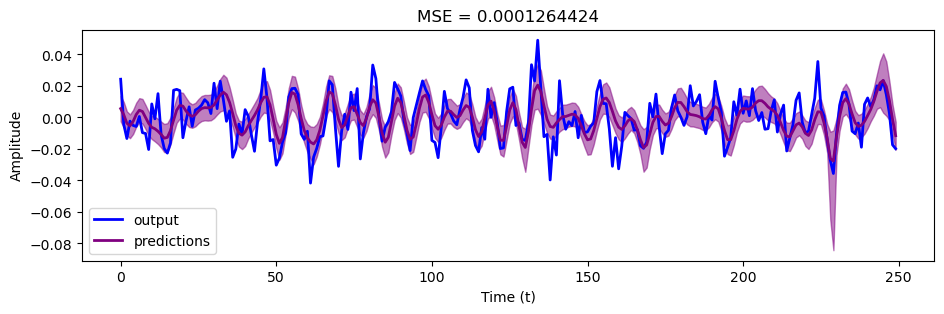

In [68]:
# Plot generated input signal
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
ax.plot(t_val, val_y, c="blue", lw=2, label="output"); 
ax.plot(t_val, mu_BNN["mean"], c="purple", lw=2, label="predictions")
ax.fill_between(t_val, mu_BNN["5%"], mu_BNN["95%"], color="purple", alpha=0.5)
ax.set_title("MSE = " + str(MSE_BNN));
ax.set_xlabel("Time (t)");
ax.set_ylabel("Amplitude");
ax.legend();

In [69]:
fig.savefig("figures/bayesian-neuralnetwork-regression.png");

In [70]:
print("MSE BLR = " + str(MSE_BLR))
print("MSE BNN = " + str(MSE_BNN))

MSE BLR = 0.0001200652
MSE BNN = 0.0001264424
